In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Helper functions

In [2]:
def data_generator(T, C, le, exclude_labels=[], max_per_class=None):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    poses = []
    labels = []
    counter = collections.Counter()
    for p, L in zip(T['pose'], T['label']):
        if L not in exclude_labels and (max_per_class is None or counter[L] < max_per_class):
            poses.append(p)
            labels.append(L)
            counter[L] += 1
    
    X = poses # list of arrays
    Y = np.zeros(shape=(len(labels), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(labels)] = 1
    return X, Y

In [3]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

In [4]:
def count_all_nan(X):
    return sum([np.count_nonzero(np.isnan(x)) for x in X])

## Load and Preprocess Data

In [5]:
# directory that contains pickle files
undoctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_pkl')
doctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_doctored_pkl')

In [6]:
# Load pickle files
Train_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_test_1.pkl"), "rb"))

Train_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train_undoctored['label'])
print("Classses: ", len(le.classes_), le.classes_)

Classses:  21 ['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave']


In [7]:
# examine some known strange videos
print(Train_undoctored.keys())
for p, L, filename in zip(Train_undoctored['pose'], Train_undoctored['label'], Train_undoctored['filename']):
    if 'Maddin_winkt_wave_h_cm_np1_fr_med_1' in filename:
        print(L, filename)
        print(p.dtype)
        print('Nose\n', p[:, 0, :])
        print('RElbow\n', p[:, 3, :])
        print('RWrist\n', p[:, 4, :])
        print('LElbow\n', p[:, 6, :])
        print('RWrist\n', p[:, 7, :])
        break

dict_keys(['pose', 'label', 'filename'])
wave wave/Maddin_winkt_wave_h_cm_np1_fr_med_1
float64
Nose
 [[217.41  111.526]
 [216.107 107.003]
 [205.713 106.334]
 [196.635 106.364]
 [197.279 106.35 ]
 [197.935 106.334]
 [198.586 106.337]
 [194.704 102.465]
 [193.385 102.465]
 [190.808 104.415]
 [190.808 104.416]
 [189.483  96.63 ]
 [193.388  95.314]
 [203.14   95.949]
 [217.418  94.665]
 [224.554  92.069]
 [225.851  92.065]
 [222.612  86.869]
 [221.977  92.076]
 [228.466  95.981]
 [231.706  96.606]
 [231.693  96.649]
 [231.06   96.64 ]
 [227.174 101.836]
 [227.805 106.336]
 [231.69  109.607]
 [232.365 110.902]
 [233.658 112.221]
 [234.944 112.222]
 [235.604 117.402]
 [234.309 117.38 ]
 [226.535 117.387]
 [221.956 121.958]
 [221.33  121.967]
 [226.492 119.36 ]
 [226.526 121.307]
 [226.538 120.659]
 [225.867 118.05 ]]
RElbow
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0

### Optionally Combine doctored and undoctored train/test

In [8]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=64)

X_doctored, Y_doctored = data_generator(Train_doctored,C,le)
X_undoctored, Y_undoctored = data_generator(Train_undoctored,C,le)

# print("Combine doctored and undoctored training sets!")
# X = X_doctored + X_undoctored
# Y = np.concatenate([Y_doctored, Y_undoctored])

X = X_undoctored
Y = Y_undoctored

# X = X_doctored
# Y = Y_doctored

X_test,Y_test = data_generator(Test_undoctored,C,le) #, exclude_labels=['climb_stairs', 'jump', 'kick_ball', 'run', 'sit', 'stand', 'walk'])
# X_test,Y_test = data_generator(Test_doctored,C,le) #, exclude_labels=['climb_stairs', 'jump', 'kick_ball', 'run', 'sit', 'stand', 'walk'])

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

630 (30, 25, 2) (630, 21)
251 (31, 25, 2) (251, 21)


## Deal with undetected joints

### NANify undetection joints

In [9]:
cleaner = ddnet.OpenPoseDataCleaner(copy=True)

X_nan = list(map(cleaner.make_nan, X))
X_test_nan = list(map(cleaner.make_nan, X_test))

### Filter on visible subset of joints

In [26]:
RWrist, LWrist = 4, 7
RElbow, LElbow = 3, 6
RShoulder, LShoulder = 2, 5
MidHip = 8

def has_joint(p, joint, thresh=3):
    return np.count_nonzero(~np.isnan(p[:,joint, 0])) >= thresh

In [27]:
# Now let's filter the points with both hands visible

X_subset, Y_subset = zip(*[(x, y) for x,y in zip(X_nan, Y) \
                           if has_joint(x, RWrist) and has_joint(x, LWrist) \
                            and has_joint(x, RElbow) and has_joint(x, LElbow) \
                            and has_joint(x, RShoulder) and has_joint(x, LShoulder)])
Y_subset=np.array(Y_subset)

X_test_subset, Y_test_subset = zip(*[(x, y) for x,y in zip(X_test_nan, Y_test) \
                                     if has_joint(x, RWrist) and has_joint(x, LWrist) \
                                     and has_joint(x, RShoulder) and has_joint(x, LShoulder)])
Y_test_subset=np.array(Y_test_subset)

print(len(X), '->', len(X_subset))
print(len(X_test), '->', len(X_test_subset))

630 -> 546
251 -> 216


### Filter good joints, temporal interpolation and normalize (still have NANs)

In [28]:
X_clean = list(map(cleaner.transform_point, X_subset))
X_test_clean = list(map(cleaner.transform_point, X_test_subset))

In [29]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=X_clean[0].shape[1], joint_dim=2, num_classes=21, num_filters=64)

X_0_nan, X_1_nan = ddnet.preprocess_batch(X_clean, C)
X_test_0_nan, X_test_1_nan = ddnet.preprocess_batch(X_test_clean, C)
print(X_0_nan[0].shape, X_1_nan[0].shape)

print(count_all_nan(X_clean))
print(count_all_nan(X_test_clean))
print(count_all_nan(X_0_nan), count_all_nan(X_1_nan))
print(count_all_nan(X_test_0_nan), count_all_nan(X_test_1_nan))

(32, 105) (32, 15, 2)
49176
17142
302624 46656
106496 16448


In [30]:
# Impute JCD with 0
X_0_imp = X_0_nan.copy()
X_0_imp[np.isnan(X_0_imp)] = 0.
X_test_0_imp = X_test_0_nan.copy()
X_test_0_imp[np.isnan(X_test_0_imp)] = 0.
print(X_0_nan[0][0])
print(X_0_imp[0][0])

# Impute Cartessian with 0
X_1_imp = X_1_nan.copy()
X_1_imp[np.isnan(X_1_imp)] = 0.
X_test_1_imp = X_test_1_nan.copy()
X_test_1_imp[np.isnan(X_test_1_imp)] = 0.
print(X_1_nan[0][0])
print(X_1_imp[0][0])

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.67236289 -0.12806191  0.34851914 -0.64562701
 -0.127683    0.24071769  0.28964901  0.3258977   1.05732743  0.30842156
  1.08297145         nan         nan -0.29555449  0.24202608 -0.31812232
  0.07823552  0.34635176  0.31814922  0.30022394  1.035761    0.39424704
  1.12121901         nan         nan -0.44721973  0.1263697   0.01945649
 -0.01153824 -0.18848676 -0.2966201   0.39888682 -0.01398037  0.55986753
         nan         nan  0.52456371  0.13465957 -0.16194191 -0.46053211
 -0.67106053 -0.13103635 -0.22094804  0.09293588         nan         nan
 -0.26004057  0.20485558  0.33732916  0.42694392  1.12431263  0.29100426
  1.08528387         nan         nan -0.4937615  -0.26375026 -0.09665573
  0.48906169 -0.39504314  0.38329644         nan         nan -0.68746891
 -0.47328433 -0.01085616 -0.89818804 -0.11639256   

In [31]:
Y_input = Y_subset
Y_test_input = Y_test_subset
X_0, X_1 = X_0_imp, X_1_imp
X_test_0, X_test_1 = X_test_0_imp, X_test_1_imp
print(X_0.shape, X_1.shape)
print(X_test_0.shape, X_test_1.shape)

(546, 32, 105) (546, 32, 15, 2)
(216, 32, 105) (216, 32, 15, 2)


# Train, Test 

### Reweight training samples

In [32]:
# rescale sample weight to balance classes
def get_sample_weight(Y):
    cls_ids = np.argmax(Y, axis=1)
    assert cls_ids.shape[0] == Y.shape[0]
    cls_histo = np.array([np.count_nonzero(cls_ids==i) for i in range(Y.shape[1])])
    cls_weight = np.max(cls_histo) / cls_histo # balanced
    print(cls_histo)
    print(cls_weight)
    sample_weight = cls_weight[cls_ids]
    assert sample_weight.shape[0] == Y.shape[0]
    return sample_weight

In [33]:
sample_weight = get_sample_weight(Y_input)
print(sample_weight.shape)
print(sample_weight[::100][:10])

[19 34 24 27 30 19 22 20 36 38 19 27 18 35 24 19 16 39 31 26 23]
[2.05263158 1.14705882 1.625      1.44444444 1.3        2.05263158
 1.77272727 1.95       1.08333333 1.02631579 2.05263158 1.44444444
 2.16666667 1.11428571 1.625      2.05263158 2.4375     1.
 1.25806452 1.5        1.69565217]
(546,)
[1.77272727 2.16666667 2.05263158 1.08333333 2.05263158 1.11428571]


### Create Net, Train and plot loss/accuracy

In [34]:
random.seed(456)

DD_Net = ddnet.build_DD_Net(C)
DD_Net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4, 512)       1714816     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 512)          0           model_3[1][0]              

In [35]:
import keras
from keras import backend as K
from keras.optimizers import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
K.set_session(sess)

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=1000,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )


Train on 546 samples, validate on 216 samples
Epoch 1/1000
546/546 [==============================] - 6s 11ms/step - loss: 5.7799 - accuracy: 0.0440 - val_loss: 3.0410 - val_accuracy: 0.0602
Epoch 2/1000
546/546 [==============================] - 0s 148us/step - loss: 5.2276 - accuracy: 0.0513 - val_loss: 3.0393 - val_accuracy: 0.0787
Epoch 3/1000
546/546 [==============================] - 0s 145us/step - loss: 4.8334 - accuracy: 0.0989 - val_loss: 3.0366 - val_accuracy: 0.0741
Epoch 4/1000
546/546 [==============================] - 0s 153us/step - loss: 4.7533 - accuracy: 0.1007 - val_loss: 3.0326 - val_accuracy: 0.1157
Epoch 5/1000
546/546 [==============================] - 0s 148us/step - loss: 4.3443 - accuracy: 0.1520 - val_loss: 3.0276 - val_accuracy: 0.1481
Epoch 6/1000
546/546 [==============================] - 0s 150us/step - loss: 4.3580 - accuracy: 0.1520 - val_loss: 3.0215 - val_accuracy: 0.1898
Epoch 7/1000
546/546 [==============================] - 0s 145us/step - loss: 4

Epoch 57/1000
546/546 [==============================] - 0s 149us/step - loss: 0.9044 - accuracy: 0.8626 - val_loss: 2.9755 - val_accuracy: 0.1991
Epoch 58/1000
546/546 [==============================] - 0s 154us/step - loss: 0.8414 - accuracy: 0.8791 - val_loss: 2.9882 - val_accuracy: 0.2083
Epoch 59/1000
546/546 [==============================] - 0s 152us/step - loss: 0.7780 - accuracy: 0.8846 - val_loss: 3.0016 - val_accuracy: 0.2083
Epoch 60/1000
546/546 [==============================] - 0s 150us/step - loss: 0.7607 - accuracy: 0.8974 - val_loss: 3.0128 - val_accuracy: 0.1991
Epoch 61/1000
546/546 [==============================] - 0s 150us/step - loss: 0.7059 - accuracy: 0.9158 - val_loss: 3.0084 - val_accuracy: 0.2130
Epoch 62/1000
546/546 [==============================] - 0s 145us/step - loss: 0.6952 - accuracy: 0.8993 - val_loss: 2.9952 - val_accuracy: 0.2176
Epoch 63/1000
546/546 [==============================] - 0s 153us/step - loss: 0.6812 - accuracy: 0.9103 - val_loss: 2

Epoch 113/1000
546/546 [==============================] - 0s 158us/step - loss: 0.1709 - accuracy: 0.9908 - val_loss: 3.3804 - val_accuracy: 0.2315
Epoch 114/1000
546/546 [==============================] - 0s 152us/step - loss: 0.1920 - accuracy: 0.9872 - val_loss: 3.3881 - val_accuracy: 0.2361
Epoch 115/1000
546/546 [==============================] - 0s 158us/step - loss: 0.1980 - accuracy: 0.9890 - val_loss: 3.4068 - val_accuracy: 0.2315
Epoch 116/1000
546/546 [==============================] - 0s 159us/step - loss: 0.1400 - accuracy: 0.9908 - val_loss: 3.4305 - val_accuracy: 0.2315
Epoch 117/1000
546/546 [==============================] - 0s 152us/step - loss: 0.1717 - accuracy: 0.9908 - val_loss: 3.4624 - val_accuracy: 0.2361
Epoch 118/1000
546/546 [==============================] - 0s 161us/step - loss: 0.1923 - accuracy: 0.9853 - val_loss: 3.4786 - val_accuracy: 0.2361
Epoch 119/1000
546/546 [==============================] - 0s 157us/step - loss: 0.1515 - accuracy: 0.9927 - val_

Epoch 169/1000
546/546 [==============================] - 0s 144us/step - loss: 0.1242 - accuracy: 0.9927 - val_loss: 3.5258 - val_accuracy: 0.2731
Epoch 170/1000
546/546 [==============================] - 0s 141us/step - loss: 0.1158 - accuracy: 0.9963 - val_loss: 3.5213 - val_accuracy: 0.2731
Epoch 171/1000
546/546 [==============================] - 0s 148us/step - loss: 0.1371 - accuracy: 0.9890 - val_loss: 3.5153 - val_accuracy: 0.2731
Epoch 172/1000
546/546 [==============================] - 0s 156us/step - loss: 0.1058 - accuracy: 1.0000 - val_loss: 3.5090 - val_accuracy: 0.2731
Epoch 173/1000
546/546 [==============================] - 0s 145us/step - loss: 0.1200 - accuracy: 0.9982 - val_loss: 3.5035 - val_accuracy: 0.2731
Epoch 174/1000
546/546 [==============================] - 0s 147us/step - loss: 0.1176 - accuracy: 0.9890 - val_loss: 3.4982 - val_accuracy: 0.2731
Epoch 175/1000
546/546 [==============================] - 0s 142us/step - loss: 0.1216 - accuracy: 0.9945 - val_

Epoch 225/1000
546/546 [==============================] - 0s 149us/step - loss: 0.1115 - accuracy: 0.9982 - val_loss: 3.2696 - val_accuracy: 0.3148
Epoch 226/1000
546/546 [==============================] - 0s 149us/step - loss: 0.1263 - accuracy: 0.9963 - val_loss: 3.2640 - val_accuracy: 0.3194
Epoch 227/1000
546/546 [==============================] - 0s 169us/step - loss: 0.1227 - accuracy: 0.9927 - val_loss: 3.2579 - val_accuracy: 0.3241
Epoch 228/1000
546/546 [==============================] - 0s 147us/step - loss: 0.1154 - accuracy: 0.9945 - val_loss: 3.2526 - val_accuracy: 0.3241
Epoch 229/1000
546/546 [==============================] - 0s 152us/step - loss: 0.1141 - accuracy: 0.9945 - val_loss: 3.2469 - val_accuracy: 0.3241
Epoch 230/1000
546/546 [==============================] - 0s 150us/step - loss: 0.0985 - accuracy: 1.0000 - val_loss: 3.2413 - val_accuracy: 0.3241
Epoch 231/1000
546/546 [==============================] - 0s 154us/step - loss: 0.1136 - accuracy: 0.9982 - val_

Epoch 281/1000
546/546 [==============================] - 0s 157us/step - loss: 0.1299 - accuracy: 0.9927 - val_loss: 2.9206 - val_accuracy: 0.3750
Epoch 282/1000
546/546 [==============================] - 0s 157us/step - loss: 0.1150 - accuracy: 0.9982 - val_loss: 2.9148 - val_accuracy: 0.3750
Epoch 283/1000
546/546 [==============================] - 0s 170us/step - loss: 0.0990 - accuracy: 0.9982 - val_loss: 2.9086 - val_accuracy: 0.3796
Epoch 284/1000
546/546 [==============================] - 0s 155us/step - loss: 0.1195 - accuracy: 0.9963 - val_loss: 2.9021 - val_accuracy: 0.3750
Epoch 285/1000
546/546 [==============================] - 0s 154us/step - loss: 0.1321 - accuracy: 0.9872 - val_loss: 2.8961 - val_accuracy: 0.3750
Epoch 286/1000
546/546 [==============================] - 0s 148us/step - loss: 0.1090 - accuracy: 0.9963 - val_loss: 2.8904 - val_accuracy: 0.3750
Epoch 287/1000
546/546 [==============================] - 0s 150us/step - loss: 0.1105 - accuracy: 0.9927 - val_

Epoch 337/1000
546/546 [==============================] - 0s 155us/step - loss: 0.1169 - accuracy: 0.9927 - val_loss: 2.5465 - val_accuracy: 0.4306
Epoch 338/1000
546/546 [==============================] - 0s 152us/step - loss: 0.1370 - accuracy: 0.9908 - val_loss: 2.5392 - val_accuracy: 0.4306
Epoch 339/1000
546/546 [==============================] - 0s 150us/step - loss: 0.1229 - accuracy: 0.9945 - val_loss: 2.5313 - val_accuracy: 0.4306
Epoch 340/1000
546/546 [==============================] - 0s 153us/step - loss: 0.1187 - accuracy: 0.9963 - val_loss: 2.5233 - val_accuracy: 0.4306
Epoch 341/1000
546/546 [==============================] - 0s 152us/step - loss: 0.1231 - accuracy: 0.9963 - val_loss: 2.5159 - val_accuracy: 0.4306
Epoch 342/1000
546/546 [==============================] - 0s 144us/step - loss: 0.1229 - accuracy: 0.9908 - val_loss: 2.5084 - val_accuracy: 0.4306
Epoch 343/1000
546/546 [==============================] - 0s 152us/step - loss: 0.1232 - accuracy: 0.9908 - val_

Epoch 393/1000
546/546 [==============================] - 0s 155us/step - loss: 0.0938 - accuracy: 0.9963 - val_loss: 2.1626 - val_accuracy: 0.4954
Epoch 394/1000
546/546 [==============================] - 0s 163us/step - loss: 0.1157 - accuracy: 0.9945 - val_loss: 2.1563 - val_accuracy: 0.4954
Epoch 395/1000
546/546 [==============================] - 0s 156us/step - loss: 0.1315 - accuracy: 0.9927 - val_loss: 2.1494 - val_accuracy: 0.4954
Epoch 396/1000
546/546 [==============================] - 0s 153us/step - loss: 0.0943 - accuracy: 0.9963 - val_loss: 2.1424 - val_accuracy: 0.5000
Epoch 397/1000
546/546 [==============================] - 0s 153us/step - loss: 0.1182 - accuracy: 0.9963 - val_loss: 2.1361 - val_accuracy: 0.5000
Epoch 398/1000
546/546 [==============================] - 0s 159us/step - loss: 0.1323 - accuracy: 0.9945 - val_loss: 2.1298 - val_accuracy: 0.5000
Epoch 399/1000
546/546 [==============================] - 0s 162us/step - loss: 0.1026 - accuracy: 1.0000 - val_

Epoch 449/1000
546/546 [==============================] - 0s 160us/step - loss: 0.1166 - accuracy: 0.9982 - val_loss: 1.8469 - val_accuracy: 0.5556
Epoch 450/1000
546/546 [==============================] - 0s 154us/step - loss: 0.1118 - accuracy: 0.9945 - val_loss: 1.8425 - val_accuracy: 0.5556
Epoch 451/1000
546/546 [==============================] - 0s 164us/step - loss: 0.1046 - accuracy: 0.9982 - val_loss: 1.8380 - val_accuracy: 0.5556
Epoch 452/1000
546/546 [==============================] - 0s 172us/step - loss: 0.1106 - accuracy: 0.9982 - val_loss: 1.8338 - val_accuracy: 0.5556
Epoch 453/1000
546/546 [==============================] - 0s 171us/step - loss: 0.1130 - accuracy: 0.9963 - val_loss: 1.8295 - val_accuracy: 0.5556
Epoch 454/1000
546/546 [==============================] - 0s 165us/step - loss: 0.1148 - accuracy: 0.9927 - val_loss: 1.8252 - val_accuracy: 0.5556
Epoch 455/1000
546/546 [==============================] - 0s 180us/step - loss: 0.0995 - accuracy: 1.0000 - val_

Epoch 505/1000
546/546 [==============================] - 0s 152us/step - loss: 0.0921 - accuracy: 0.9982 - val_loss: 1.6330 - val_accuracy: 0.5972
Epoch 506/1000
546/546 [==============================] - 0s 148us/step - loss: 0.0956 - accuracy: 0.9982 - val_loss: 1.6300 - val_accuracy: 0.5972
Epoch 507/1000
546/546 [==============================] - 0s 154us/step - loss: 0.1149 - accuracy: 0.9963 - val_loss: 1.6270 - val_accuracy: 0.5972
Epoch 508/1000
546/546 [==============================] - 0s 153us/step - loss: 0.1069 - accuracy: 0.9945 - val_loss: 1.6238 - val_accuracy: 0.5972
Epoch 509/1000
546/546 [==============================] - 0s 149us/step - loss: 0.1080 - accuracy: 0.9982 - val_loss: 1.6207 - val_accuracy: 0.5972
Epoch 510/1000
546/546 [==============================] - 0s 141us/step - loss: 0.0916 - accuracy: 1.0000 - val_loss: 1.6178 - val_accuracy: 0.6019
Epoch 511/1000
546/546 [==============================] - 0s 156us/step - loss: 0.1141 - accuracy: 0.9927 - val_

Epoch 561/1000
546/546 [==============================] - 0s 153us/step - loss: 0.1202 - accuracy: 0.9927 - val_loss: 1.5158 - val_accuracy: 0.6111
Epoch 562/1000
546/546 [==============================] - 0s 165us/step - loss: 0.1073 - accuracy: 0.9945 - val_loss: 1.5141 - val_accuracy: 0.6111
Epoch 563/1000
546/546 [==============================] - 0s 164us/step - loss: 0.0896 - accuracy: 0.9945 - val_loss: 1.5125 - val_accuracy: 0.6157
Epoch 564/1000
546/546 [==============================] - 0s 156us/step - loss: 0.0827 - accuracy: 0.9963 - val_loss: 1.5110 - val_accuracy: 0.6204
Epoch 565/1000
546/546 [==============================] - 0s 154us/step - loss: 0.0847 - accuracy: 1.0000 - val_loss: 1.5094 - val_accuracy: 0.6204
Epoch 566/1000
546/546 [==============================] - 0s 165us/step - loss: 0.1168 - accuracy: 0.9963 - val_loss: 1.5081 - val_accuracy: 0.6204
Epoch 567/1000
546/546 [==============================] - 0s 164us/step - loss: 0.1153 - accuracy: 0.9945 - val_

Epoch 617/1000
546/546 [==============================] - 0s 149us/step - loss: 0.1028 - accuracy: 0.9982 - val_loss: 1.4464 - val_accuracy: 0.6296
Epoch 618/1000
546/546 [==============================] - 0s 148us/step - loss: 0.1043 - accuracy: 0.9945 - val_loss: 1.4456 - val_accuracy: 0.6296
Epoch 619/1000
546/546 [==============================] - 0s 159us/step - loss: 0.1230 - accuracy: 0.9963 - val_loss: 1.4449 - val_accuracy: 0.6296
Epoch 620/1000
546/546 [==============================] - 0s 145us/step - loss: 0.1173 - accuracy: 0.9963 - val_loss: 1.4439 - val_accuracy: 0.6343
Epoch 621/1000
546/546 [==============================] - 0s 153us/step - loss: 0.0899 - accuracy: 0.9963 - val_loss: 1.4431 - val_accuracy: 0.6343
Epoch 622/1000
546/546 [==============================] - 0s 155us/step - loss: 0.1332 - accuracy: 0.9927 - val_loss: 1.4423 - val_accuracy: 0.6343
Epoch 623/1000
546/546 [==============================] - 0s 154us/step - loss: 0.1021 - accuracy: 0.9982 - val_

Epoch 673/1000
546/546 [==============================] - 0s 160us/step - loss: 0.0951 - accuracy: 0.9963 - val_loss: 1.4177 - val_accuracy: 0.6343
Epoch 674/1000
546/546 [==============================] - 0s 146us/step - loss: 0.1110 - accuracy: 0.9982 - val_loss: 1.4174 - val_accuracy: 0.6296
Epoch 675/1000
546/546 [==============================] - 0s 140us/step - loss: 0.1172 - accuracy: 0.9908 - val_loss: 1.4171 - val_accuracy: 0.6296
Epoch 676/1000
546/546 [==============================] - 0s 144us/step - loss: 0.1052 - accuracy: 0.9908 - val_loss: 1.4168 - val_accuracy: 0.6296
Epoch 677/1000
546/546 [==============================] - 0s 158us/step - loss: 0.1036 - accuracy: 0.9963 - val_loss: 1.4162 - val_accuracy: 0.6296
Epoch 678/1000
546/546 [==============================] - 0s 146us/step - loss: 0.1130 - accuracy: 0.9927 - val_loss: 1.4158 - val_accuracy: 0.6296
Epoch 679/1000
546/546 [==============================] - 0s 153us/step - loss: 0.1054 - accuracy: 0.9963 - val_

Epoch 729/1000
546/546 [==============================] - 0s 165us/step - loss: 0.0844 - accuracy: 0.9982 - val_loss: 1.3949 - val_accuracy: 0.6481
Epoch 730/1000
546/546 [==============================] - 0s 150us/step - loss: 0.1150 - accuracy: 0.9963 - val_loss: 1.3947 - val_accuracy: 0.6481
Epoch 731/1000
546/546 [==============================] - 0s 146us/step - loss: 0.1185 - accuracy: 0.9963 - val_loss: 1.3944 - val_accuracy: 0.6481
Epoch 732/1000
546/546 [==============================] - 0s 146us/step - loss: 0.0895 - accuracy: 0.9945 - val_loss: 1.3942 - val_accuracy: 0.6481
Epoch 733/1000
546/546 [==============================] - 0s 165us/step - loss: 0.0886 - accuracy: 0.9982 - val_loss: 1.3941 - val_accuracy: 0.6481
Epoch 734/1000
546/546 [==============================] - 0s 171us/step - loss: 0.0976 - accuracy: 0.9963 - val_loss: 1.3940 - val_accuracy: 0.6481
Epoch 735/1000
546/546 [==============================] - 0s 157us/step - loss: 0.0906 - accuracy: 0.9982 - val_

Epoch 785/1000
546/546 [==============================] - 0s 160us/step - loss: 0.1007 - accuracy: 0.9982 - val_loss: 1.3972 - val_accuracy: 0.6435
Epoch 786/1000
546/546 [==============================] - 0s 167us/step - loss: 0.0855 - accuracy: 1.0000 - val_loss: 1.3971 - val_accuracy: 0.6435
Epoch 787/1000
546/546 [==============================] - 0s 160us/step - loss: 0.0919 - accuracy: 0.9927 - val_loss: 1.3968 - val_accuracy: 0.6435
Epoch 788/1000
546/546 [==============================] - 0s 156us/step - loss: 0.1029 - accuracy: 0.9982 - val_loss: 1.3967 - val_accuracy: 0.6435
Epoch 789/1000
546/546 [==============================] - 0s 162us/step - loss: 0.1177 - accuracy: 0.9890 - val_loss: 1.3966 - val_accuracy: 0.6435
Epoch 790/1000
546/546 [==============================] - 0s 159us/step - loss: 0.0838 - accuracy: 0.9982 - val_loss: 1.3967 - val_accuracy: 0.6435
Epoch 791/1000
546/546 [==============================] - 0s 156us/step - loss: 0.1073 - accuracy: 0.9982 - val_

Epoch 841/1000
546/546 [==============================] - 0s 153us/step - loss: 0.1013 - accuracy: 0.9945 - val_loss: 1.3941 - val_accuracy: 0.6528
Epoch 842/1000
546/546 [==============================] - 0s 159us/step - loss: 0.0857 - accuracy: 1.0000 - val_loss: 1.3938 - val_accuracy: 0.6528
Epoch 843/1000
546/546 [==============================] - 0s 156us/step - loss: 0.1156 - accuracy: 0.9927 - val_loss: 1.3940 - val_accuracy: 0.6528
Epoch 844/1000
546/546 [==============================] - 0s 151us/step - loss: 0.1138 - accuracy: 0.9945 - val_loss: 1.3941 - val_accuracy: 0.6528
Epoch 845/1000
546/546 [==============================] - 0s 152us/step - loss: 0.0990 - accuracy: 0.9927 - val_loss: 1.3941 - val_accuracy: 0.6528
Epoch 846/1000
546/546 [==============================] - 0s 177us/step - loss: 0.0935 - accuracy: 0.9945 - val_loss: 1.3942 - val_accuracy: 0.6528
Epoch 847/1000
546/546 [==============================] - 0s 158us/step - loss: 0.1093 - accuracy: 0.9945 - val_

Epoch 897/1000
546/546 [==============================] - 0s 160us/step - loss: 0.1110 - accuracy: 0.9963 - val_loss: 1.3952 - val_accuracy: 0.6528
Epoch 898/1000
546/546 [==============================] - 0s 149us/step - loss: 0.0909 - accuracy: 0.9945 - val_loss: 1.3952 - val_accuracy: 0.6528
Epoch 899/1000
546/546 [==============================] - 0s 149us/step - loss: 0.0898 - accuracy: 1.0000 - val_loss: 1.3952 - val_accuracy: 0.6528
Epoch 900/1000
546/546 [==============================] - 0s 153us/step - loss: 0.0940 - accuracy: 0.9945 - val_loss: 1.3952 - val_accuracy: 0.6528
Epoch 901/1000
546/546 [==============================] - 0s 150us/step - loss: 0.0936 - accuracy: 1.0000 - val_loss: 1.3951 - val_accuracy: 0.6528
Epoch 902/1000
546/546 [==============================] - 0s 149us/step - loss: 0.0892 - accuracy: 0.9963 - val_loss: 1.3952 - val_accuracy: 0.6528
Epoch 903/1000
546/546 [==============================] - 0s 146us/step - loss: 0.1022 - accuracy: 0.9982 - val_

Epoch 953/1000
546/546 [==============================] - 0s 154us/step - loss: 0.1012 - accuracy: 0.9945 - val_loss: 1.4023 - val_accuracy: 0.6528
Epoch 954/1000
546/546 [==============================] - 0s 151us/step - loss: 0.0987 - accuracy: 0.9908 - val_loss: 1.4025 - val_accuracy: 0.6528
Epoch 955/1000
546/546 [==============================] - 0s 150us/step - loss: 0.0928 - accuracy: 0.9963 - val_loss: 1.4028 - val_accuracy: 0.6528
Epoch 956/1000
546/546 [==============================] - 0s 147us/step - loss: 0.0895 - accuracy: 1.0000 - val_loss: 1.4028 - val_accuracy: 0.6528
Epoch 957/1000
546/546 [==============================] - 0s 152us/step - loss: 0.0986 - accuracy: 0.9982 - val_loss: 1.4031 - val_accuracy: 0.6528
Epoch 958/1000
546/546 [==============================] - 0s 142us/step - loss: 0.0863 - accuracy: 0.9982 - val_loss: 1.4033 - val_accuracy: 0.6528
Epoch 959/1000
546/546 [==============================] - 0s 150us/step - loss: 0.1100 - accuracy: 0.9908 - val_

Epoch 9/400
546/546 [==============================] - 0s 158us/step - loss: 0.0804 - accuracy: 0.9963 - val_loss: 1.3962 - val_accuracy: 0.6389
Epoch 10/400
546/546 [==============================] - 0s 175us/step - loss: 0.0802 - accuracy: 0.9963 - val_loss: 1.3962 - val_accuracy: 0.6389
Epoch 11/400
546/546 [==============================] - 0s 177us/step - loss: 0.1018 - accuracy: 0.9908 - val_loss: 1.3934 - val_accuracy: 0.6343
Epoch 12/400
546/546 [==============================] - 0s 165us/step - loss: 0.0898 - accuracy: 0.9982 - val_loss: 1.3914 - val_accuracy: 0.6296
Epoch 13/400
546/546 [==============================] - 0s 171us/step - loss: 0.0921 - accuracy: 0.9945 - val_loss: 1.3895 - val_accuracy: 0.6296
Epoch 14/400
546/546 [==============================] - 0s 174us/step - loss: 0.1014 - accuracy: 0.9945 - val_loss: 1.3874 - val_accuracy: 0.6296
Epoch 15/400
546/546 [==============================] - 0s 170us/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 1.3862 - 

Epoch 66/400
546/546 [==============================] - 0s 164us/step - loss: 0.0912 - accuracy: 0.9963 - val_loss: 1.3953 - val_accuracy: 0.6389
Epoch 67/400
546/546 [==============================] - 0s 163us/step - loss: 0.0912 - accuracy: 0.9982 - val_loss: 1.3953 - val_accuracy: 0.6435
Epoch 68/400
546/546 [==============================] - 0s 159us/step - loss: 0.0873 - accuracy: 0.9945 - val_loss: 1.3953 - val_accuracy: 0.6435
Epoch 69/400
546/546 [==============================] - 0s 161us/step - loss: 0.1094 - accuracy: 0.9927 - val_loss: 1.3955 - val_accuracy: 0.6435
Epoch 70/400
546/546 [==============================] - 0s 171us/step - loss: 0.0765 - accuracy: 0.9963 - val_loss: 1.3955 - val_accuracy: 0.6435
Epoch 71/400
546/546 [==============================] - 0s 162us/step - loss: 0.0888 - accuracy: 0.9982 - val_loss: 1.3955 - val_accuracy: 0.6435
Epoch 72/400
546/546 [==============================] - 0s 167us/step - loss: 0.0813 - accuracy: 0.9982 - val_loss: 1.3956 -

Epoch 122/400
546/546 [==============================] - 0s 163us/step - loss: 0.0946 - accuracy: 0.9982 - val_loss: 1.3990 - val_accuracy: 0.6435
Epoch 123/400
546/546 [==============================] - 0s 157us/step - loss: 0.0820 - accuracy: 0.9982 - val_loss: 1.3989 - val_accuracy: 0.6435
Epoch 124/400
546/546 [==============================] - 0s 160us/step - loss: 0.0902 - accuracy: 0.9927 - val_loss: 1.3990 - val_accuracy: 0.6435
Epoch 125/400
546/546 [==============================] - 0s 164us/step - loss: 0.0938 - accuracy: 0.9982 - val_loss: 1.3991 - val_accuracy: 0.6435
Epoch 126/400
546/546 [==============================] - 0s 167us/step - loss: 0.1029 - accuracy: 0.9945 - val_loss: 1.3992 - val_accuracy: 0.6435
Epoch 127/400
546/546 [==============================] - 0s 159us/step - loss: 0.0849 - accuracy: 0.9982 - val_loss: 1.3992 - val_accuracy: 0.6435
Epoch 128/400
546/546 [==============================] - 0s 156us/step - loss: 0.0879 - accuracy: 0.9982 - val_loss: 1

Epoch 178/400
546/546 [==============================] - 0s 163us/step - loss: 0.0976 - accuracy: 0.9927 - val_loss: 1.4030 - val_accuracy: 0.6528
Epoch 179/400
546/546 [==============================] - 0s 162us/step - loss: 0.0923 - accuracy: 0.9963 - val_loss: 1.4030 - val_accuracy: 0.6528
Epoch 180/400
546/546 [==============================] - 0s 169us/step - loss: 0.0892 - accuracy: 0.9982 - val_loss: 1.4031 - val_accuracy: 0.6528
Epoch 181/400
546/546 [==============================] - 0s 170us/step - loss: 0.0826 - accuracy: 0.9982 - val_loss: 1.4032 - val_accuracy: 0.6528
Epoch 182/400
546/546 [==============================] - 0s 171us/step - loss: 0.0969 - accuracy: 0.9945 - val_loss: 1.4031 - val_accuracy: 0.6528
Epoch 183/400
546/546 [==============================] - 0s 153us/step - loss: 0.0924 - accuracy: 0.9982 - val_loss: 1.4028 - val_accuracy: 0.6528
Epoch 184/400
546/546 [==============================] - 0s 161us/step - loss: 0.0712 - accuracy: 1.0000 - val_loss: 1

Epoch 234/400
546/546 [==============================] - 0s 182us/step - loss: 0.0854 - accuracy: 0.9963 - val_loss: 1.4055 - val_accuracy: 0.6481
Epoch 235/400
546/546 [==============================] - 0s 154us/step - loss: 0.0793 - accuracy: 0.9982 - val_loss: 1.4057 - val_accuracy: 0.6481
Epoch 236/400
546/546 [==============================] - 0s 169us/step - loss: 0.0773 - accuracy: 1.0000 - val_loss: 1.4059 - val_accuracy: 0.6481
Epoch 237/400
546/546 [==============================] - 0s 176us/step - loss: 0.0922 - accuracy: 1.0000 - val_loss: 1.4061 - val_accuracy: 0.6481
Epoch 238/400
546/546 [==============================] - 0s 162us/step - loss: 0.0743 - accuracy: 1.0000 - val_loss: 1.4062 - val_accuracy: 0.6481
Epoch 239/400
546/546 [==============================] - 0s 160us/step - loss: 0.0770 - accuracy: 0.9982 - val_loss: 1.4063 - val_accuracy: 0.6481
Epoch 240/400
546/546 [==============================] - 0s 154us/step - loss: 0.0826 - accuracy: 0.9963 - val_loss: 1

Epoch 290/400
546/546 [==============================] - 0s 166us/step - loss: 0.0809 - accuracy: 0.9945 - val_loss: 1.4175 - val_accuracy: 0.6389
Epoch 291/400
546/546 [==============================] - 0s 171us/step - loss: 0.1002 - accuracy: 0.9945 - val_loss: 1.4178 - val_accuracy: 0.6389
Epoch 292/400
546/546 [==============================] - 0s 165us/step - loss: 0.0771 - accuracy: 1.0000 - val_loss: 1.4181 - val_accuracy: 0.6389
Epoch 293/400
546/546 [==============================] - 0s 154us/step - loss: 0.0956 - accuracy: 1.0000 - val_loss: 1.4183 - val_accuracy: 0.6389
Epoch 294/400
546/546 [==============================] - 0s 164us/step - loss: 0.0799 - accuracy: 0.9982 - val_loss: 1.4184 - val_accuracy: 0.6389
Epoch 295/400
546/546 [==============================] - 0s 154us/step - loss: 0.1084 - accuracy: 0.9963 - val_loss: 1.4186 - val_accuracy: 0.6389
Epoch 296/400
546/546 [==============================] - 0s 160us/step - loss: 0.0784 - accuracy: 0.9945 - val_loss: 1

Epoch 346/400
546/546 [==============================] - 0s 167us/step - loss: 0.0867 - accuracy: 0.9945 - val_loss: 1.4116 - val_accuracy: 0.6435
Epoch 347/400
546/546 [==============================] - 0s 160us/step - loss: 0.0871 - accuracy: 0.9963 - val_loss: 1.4117 - val_accuracy: 0.6435
Epoch 348/400
546/546 [==============================] - 0s 160us/step - loss: 0.0809 - accuracy: 1.0000 - val_loss: 1.4121 - val_accuracy: 0.6435
Epoch 349/400
546/546 [==============================] - 0s 167us/step - loss: 0.0716 - accuracy: 0.9982 - val_loss: 1.4122 - val_accuracy: 0.6435
Epoch 350/400
546/546 [==============================] - 0s 152us/step - loss: 0.0957 - accuracy: 0.9963 - val_loss: 1.4124 - val_accuracy: 0.6435
Epoch 351/400
546/546 [==============================] - 0s 161us/step - loss: 0.0814 - accuracy: 0.9982 - val_loss: 1.4126 - val_accuracy: 0.6435
Epoch 352/400
546/546 [==============================] - 0s 169us/step - loss: 0.0744 - accuracy: 0.9982 - val_loss: 1

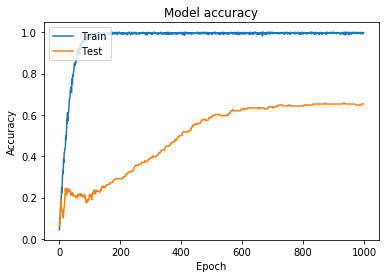

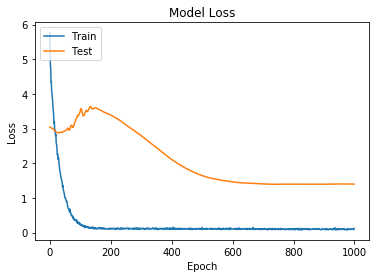

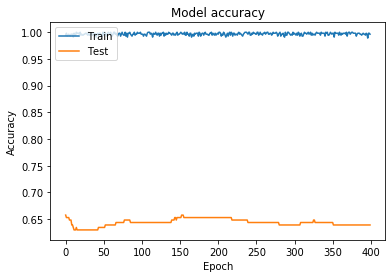

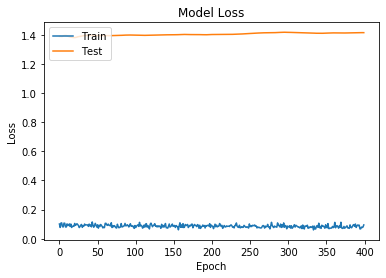

In [36]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [37]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

[[ 2  0  2  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  1  0  2  0  1  0  0  0  2  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  3  0  1  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  3  0  1  0  0  0  0  0  0  0  1  1  0  1  0  0]
 [ 0  0  0  0  0  2  2  0  0  1  0  2  0  0  0  0  0  0  1  2  0]
 [ 0  0  0  1  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  8  0  0  0  0  0  1  0  0  1  0]
 [ 0  0  0  3  0  0  1  0  0  0  0  2  0  0  0  0  0  0  2  0  1]
 [ 0  1  0  0  0  0  0  0  0  1  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0 13  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  2  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0

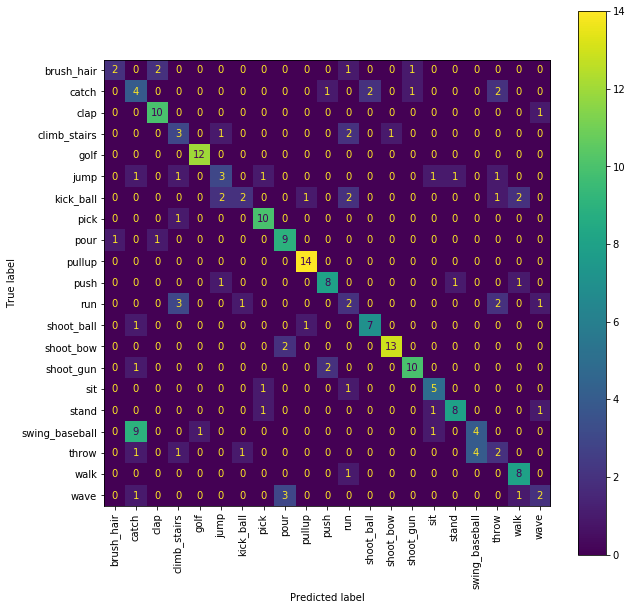

In [38]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test_input, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_) #sorted(set(le.inverse_transform(Y_test_cls))))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

In [39]:
# other statistics
import pandas as pd
from sklearn.metrics import average_precision_score

df = pd.DataFrame()

for i, cls_name in enumerate(le.classes_):
    precision = np.round(cm[i, i] / np.sum(cm[:, i]), 2)
    recall = np.round(cm[i, i] / np.sum(cm[i, :]), 2)
    train_size =  list(le.inverse_transform(np.argmax(Y_input, axis=1))).count(cls_name)
    test_size =  list(le.inverse_transform(np.argmax(Y_test_input, axis=1))).count(cls_name)

    ap = average_precision_score(Y_test_input[:, i], Y_test_pred[:, i])
        
    df = df.append({
        'class_name': cls_name,
        'precision': precision,
        'recall': recall,
        'train_size': train_size,
        'test_size': test_size,
        '1-vs-all AP': ap 
    }, ignore_index=True)

print(df.round(3))

    1-vs-all AP      class_name  precision  recall  test_size  train_size
0         0.459      brush_hair       0.67    0.33        6.0        19.0
1         0.260           catch       0.22    0.40       10.0        34.0
2         0.940            clap       0.77    0.91       11.0        24.0
3         0.352    climb_stairs       0.33    0.43        7.0        27.0
4         0.994            golf       0.92    1.00       12.0        30.0
5         0.463            jump       0.43    0.33        9.0        19.0
6         0.441       kick_ball       0.50    0.20       10.0        22.0
7         0.899            pick       0.77    0.91       11.0        20.0
8         0.837            pour       0.64    0.82       11.0        36.0
9         0.991          pullup       0.88    1.00       14.0        38.0
10        0.753            push       0.73    0.73       11.0        19.0
11        0.207             run       0.22    0.22        9.0        27.0
12        0.848      shoot_ball       

### Save model to disk

In [40]:
model_path = 'jhmdb_openpose_model_15.h5'
ddnet.save_DDNet(DD_Net, model_path)

### Examine wrong predictions

In [ ]:
def check_labels(Y_true, Y_pred, le, filenames, labels=['wave']):
    assert Y_true.shape[0] == Y_pred.shape[0] == len(filenames)
    for yt, yp, fn in zip(Y_true, Y_pred, filenames):
        cls_true = np.argmax(yt)
        cls_pred = np.argmax(yp)
        if le.inverse_transform([cls_true])[0] in labels:
            correct = (cls_true == cls_pred)
            print("{} \t{}={:.2f} \t{}={:.2f} \t{}".format(
                correct,
                le.inverse_transform([cls_pred])[0],
                np.max(yp),
                labels[0],
                yp[cls_true],
                fn
            ))
            
check_labels(Y_test_input, Y_test_pred, le, Test_undoctored['filename'])

### Refit using Training + Test Data

In [41]:
print(Y_input.shape, Y_test_input.shape)
X_rf_0 = np.concatenate([X_0, X_test_0])
X_rf_1 = np.concatenate([X_1, X_test_1])
Y_rf = np.concatenate([Y_input, Y_test_input])
assert X_rf_0.shape[0] == X_rf_1.shape[0] == Y_rf.shape[0]
print("Refit using {} samples".format(Y_rf.shape[0]))
rf_sample_weight = get_sample_weight(Y_rf)

(546, 21) (216, 21)
Refit using 762 samples
[25 44 35 34 42 28 32 31 47 52 30 36 27 50 37 26 27 54 40 35 30]
[2.16       1.22727273 1.54285714 1.58823529 1.28571429 1.92857143
 1.6875     1.74193548 1.14893617 1.03846154 1.8        1.5
 2.         1.08       1.45945946 2.07692308 2.         1.
 1.35       1.54285714 1.8       ]


In [42]:
# create a new net
rf_net = ddnet.create_DDNet(C)

lr = 1e-3
rf_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = rf_net.fit([X_rf_0,X_rf_1],Y_rf,
                    batch_size=len(Y_rf),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=rf_sample_weight
                    )

lr = 1e-4
rf_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history2 = rf_net.fit([X_rf_0,X_rf_1],Y_rf,
                    batch_size=len(Y_rf),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=rf_sample_weight
                    )

Epoch 1/800
762/762 [==============================] - 5s 7ms/step - loss: 5.5851 - accuracy: 0.0564
Epoch 2/800
762/762 [==============================] - 0s 114us/step - loss: 5.0997 - accuracy: 0.0748
Epoch 3/800
762/762 [==============================] - 0s 113us/step - loss: 4.7201 - accuracy: 0.1168
Epoch 4/800
762/762 [==============================] - 0s 110us/step - loss: 4.4563 - accuracy: 0.1575
Epoch 5/800
762/762 [==============================] - 0s 107us/step - loss: 4.2628 - accuracy: 0.1693
Epoch 6/800
762/762 [==============================] - 0s 106us/step - loss: 4.1836 - accuracy: 0.1903
Epoch 7/800
762/762 [==============================] - 0s 108us/step - loss: 3.9911 - accuracy: 0.1982
Epoch 8/800
762/762 [==============================] - 0s 108us/step - loss: 3.9079 - accuracy: 0.2165
Epoch 9/800
762/762 [==============================] - 0s 102us/step - loss: 3.6456 - accuracy: 0.2612
Epoch 10/800
762/762 [==============================] - 0s 104us/step - los

Epoch 81/800
762/762 [==============================] - 0s 95us/step - loss: 0.4471 - accuracy: 0.9514
Epoch 82/800
762/762 [==============================] - 0s 92us/step - loss: 0.3996 - accuracy: 0.9619
Epoch 83/800
762/762 [==============================] - 0s 97us/step - loss: 0.3832 - accuracy: 0.9659
Epoch 84/800
762/762 [==============================] - 0s 97us/step - loss: 0.3988 - accuracy: 0.9514
Epoch 85/800
762/762 [==============================] - 0s 96us/step - loss: 0.4040 - accuracy: 0.9488
Epoch 86/800
762/762 [==============================] - 0s 102us/step - loss: 0.3785 - accuracy: 0.9646
Epoch 87/800
762/762 [==============================] - 0s 100us/step - loss: 0.3394 - accuracy: 0.9685
Epoch 88/800
762/762 [==============================] - 0s 96us/step - loss: 0.3307 - accuracy: 0.9659
Epoch 89/800
762/762 [==============================] - 0s 93us/step - loss: 0.3849 - accuracy: 0.9554
Epoch 90/800
762/762 [==============================] - 0s 95us/step - 

Epoch 160/800
762/762 [==============================] - 0s 95us/step - loss: 0.1382 - accuracy: 0.9869
Epoch 161/800
762/762 [==============================] - 0s 90us/step - loss: 0.1312 - accuracy: 0.9948
Epoch 162/800
762/762 [==============================] - 0s 96us/step - loss: 0.1479 - accuracy: 0.9921
Epoch 163/800
762/762 [==============================] - 0s 99us/step - loss: 0.1182 - accuracy: 0.9921
Epoch 164/800
762/762 [==============================] - 0s 94us/step - loss: 0.1355 - accuracy: 0.9908
Epoch 165/800
762/762 [==============================] - 0s 99us/step - loss: 0.1328 - accuracy: 0.9908
Epoch 166/800
762/762 [==============================] - 0s 103us/step - loss: 0.1137 - accuracy: 0.9974
Epoch 167/800
762/762 [==============================] - 0s 96us/step - loss: 0.1187 - accuracy: 0.9974
Epoch 168/800
762/762 [==============================] - 0s 104us/step - loss: 0.1328 - accuracy: 0.9934
Epoch 169/800
762/762 [==============================] - 0s 94

Epoch 239/800
762/762 [==============================] - 0s 97us/step - loss: 0.1276 - accuracy: 0.9934
Epoch 240/800
762/762 [==============================] - 0s 97us/step - loss: 0.1411 - accuracy: 0.9882
Epoch 241/800
762/762 [==============================] - 0s 104us/step - loss: 0.1290 - accuracy: 0.9921
Epoch 242/800
762/762 [==============================] - 0s 98us/step - loss: 0.1280 - accuracy: 0.9921
Epoch 243/800
762/762 [==============================] - 0s 99us/step - loss: 0.1230 - accuracy: 0.9948
Epoch 244/800
762/762 [==============================] - 0s 95us/step - loss: 0.1276 - accuracy: 0.9961
Epoch 245/800
762/762 [==============================] - 0s 96us/step - loss: 0.1116 - accuracy: 0.9974
Epoch 246/800
762/762 [==============================] - 0s 103us/step - loss: 0.1161 - accuracy: 0.9974
Epoch 247/800
762/762 [==============================] - 0s 105us/step - loss: 0.1074 - accuracy: 0.9987
Epoch 248/800
762/762 [==============================] - 0s 1

Epoch 318/800
762/762 [==============================] - 0s 92us/step - loss: 0.1262 - accuracy: 0.9948
Epoch 319/800
762/762 [==============================] - 0s 95us/step - loss: 0.1038 - accuracy: 0.9974
Epoch 320/800
762/762 [==============================] - 0s 101us/step - loss: 0.1097 - accuracy: 0.9961
Epoch 321/800
762/762 [==============================] - 0s 96us/step - loss: 0.1260 - accuracy: 0.9908
Epoch 322/800
762/762 [==============================] - 0s 98us/step - loss: 0.1264 - accuracy: 0.9948
Epoch 323/800
762/762 [==============================] - 0s 106us/step - loss: 0.1235 - accuracy: 0.9934
Epoch 324/800
762/762 [==============================] - 0s 97us/step - loss: 0.1149 - accuracy: 0.9921
Epoch 325/800
762/762 [==============================] - 0s 102us/step - loss: 0.1404 - accuracy: 0.9948
Epoch 326/800
762/762 [==============================] - 0s 98us/step - loss: 0.1317 - accuracy: 0.9908
Epoch 327/800
762/762 [==============================] - 0s 1

Epoch 397/800
762/762 [==============================] - 0s 90us/step - loss: 0.1132 - accuracy: 0.9961
Epoch 398/800
762/762 [==============================] - 0s 94us/step - loss: 0.1079 - accuracy: 0.9921
Epoch 399/800
762/762 [==============================] - 0s 94us/step - loss: 0.1278 - accuracy: 0.9882
Epoch 400/800
762/762 [==============================] - 0s 93us/step - loss: 0.1194 - accuracy: 0.9869
Epoch 401/800
762/762 [==============================] - 0s 92us/step - loss: 0.1213 - accuracy: 0.9895
Epoch 402/800
762/762 [==============================] - 0s 91us/step - loss: 0.1251 - accuracy: 0.9948
Epoch 403/800
762/762 [==============================] - 0s 93us/step - loss: 0.1314 - accuracy: 0.9934
Epoch 404/800
762/762 [==============================] - 0s 92us/step - loss: 0.1369 - accuracy: 0.9908
Epoch 405/800
762/762 [==============================] - 0s 91us/step - loss: 0.0996 - accuracy: 0.9961
Epoch 406/800
762/762 [==============================] - 0s 90us

Epoch 476/800
762/762 [==============================] - 0s 102us/step - loss: 0.1231 - accuracy: 0.9921
Epoch 477/800
762/762 [==============================] - 0s 98us/step - loss: 0.1184 - accuracy: 0.9921
Epoch 478/800
762/762 [==============================] - 0s 95us/step - loss: 0.1251 - accuracy: 0.9961
Epoch 479/800
762/762 [==============================] - 0s 100us/step - loss: 0.1285 - accuracy: 0.9948
Epoch 480/800
762/762 [==============================] - 0s 96us/step - loss: 0.1136 - accuracy: 0.9921
Epoch 481/800
762/762 [==============================] - 0s 94us/step - loss: 0.1155 - accuracy: 0.9948
Epoch 482/800
762/762 [==============================] - 0s 93us/step - loss: 0.1255 - accuracy: 0.9934
Epoch 483/800
762/762 [==============================] - 0s 103us/step - loss: 0.1281 - accuracy: 0.9934
Epoch 484/800
762/762 [==============================] - 0s 96us/step - loss: 0.1102 - accuracy: 0.9948
Epoch 485/800
762/762 [==============================] - 0s 1

Epoch 555/800
762/762 [==============================] - 0s 105us/step - loss: 0.1186 - accuracy: 0.9948
Epoch 556/800
762/762 [==============================] - 0s 102us/step - loss: 0.1212 - accuracy: 0.9934
Epoch 557/800
762/762 [==============================] - 0s 103us/step - loss: 0.1279 - accuracy: 0.9895
Epoch 558/800
762/762 [==============================] - 0s 99us/step - loss: 0.1075 - accuracy: 0.9934
Epoch 559/800
762/762 [==============================] - 0s 103us/step - loss: 0.1389 - accuracy: 0.9921
Epoch 560/800
762/762 [==============================] - 0s 103us/step - loss: 0.1127 - accuracy: 0.9934
Epoch 561/800
762/762 [==============================] - 0s 101us/step - loss: 0.1112 - accuracy: 0.9948
Epoch 562/800
762/762 [==============================] - 0s 108us/step - loss: 0.1240 - accuracy: 0.9934
Epoch 563/800
762/762 [==============================] - 0s 97us/step - loss: 0.1236 - accuracy: 0.9961
Epoch 564/800
762/762 [==============================] - 

Epoch 634/800
762/762 [==============================] - 0s 92us/step - loss: 0.1091 - accuracy: 0.9974
Epoch 635/800
762/762 [==============================] - 0s 96us/step - loss: 0.1264 - accuracy: 0.9974
Epoch 636/800
762/762 [==============================] - 0s 99us/step - loss: 0.1208 - accuracy: 0.9948
Epoch 637/800
762/762 [==============================] - 0s 102us/step - loss: 0.1073 - accuracy: 0.9921
Epoch 638/800
762/762 [==============================] - 0s 106us/step - loss: 0.1083 - accuracy: 0.9948
Epoch 639/800
762/762 [==============================] - 0s 105us/step - loss: 0.1183 - accuracy: 0.9895
Epoch 640/800
762/762 [==============================] - 0s 112us/step - loss: 0.1105 - accuracy: 0.9934
Epoch 641/800
762/762 [==============================] - 0s 108us/step - loss: 0.1374 - accuracy: 0.9882
Epoch 642/800
762/762 [==============================] - 0s 104us/step - loss: 0.1195 - accuracy: 0.9908
Epoch 643/800
762/762 [==============================] - 0

Epoch 713/800
762/762 [==============================] - 0s 98us/step - loss: 0.1073 - accuracy: 0.9974
Epoch 714/800
762/762 [==============================] - 0s 99us/step - loss: 0.0996 - accuracy: 0.9961
Epoch 715/800
762/762 [==============================] - 0s 98us/step - loss: 0.1004 - accuracy: 0.9974
Epoch 716/800
762/762 [==============================] - 0s 100us/step - loss: 0.1298 - accuracy: 0.9948
Epoch 717/800
762/762 [==============================] - 0s 107us/step - loss: 0.1050 - accuracy: 0.9974
Epoch 718/800
762/762 [==============================] - 0s 99us/step - loss: 0.1128 - accuracy: 0.9921
Epoch 719/800
762/762 [==============================] - 0s 103us/step - loss: 0.1059 - accuracy: 0.9987
Epoch 720/800
762/762 [==============================] - 0s 101us/step - loss: 0.1094 - accuracy: 0.9934
Epoch 721/800
762/762 [==============================] - 0s 90us/step - loss: 0.1142 - accuracy: 0.9934
Epoch 722/800
762/762 [==============================] - 0s 

Epoch 792/800
762/762 [==============================] - 0s 95us/step - loss: 0.1144 - accuracy: 0.9961
Epoch 793/800
762/762 [==============================] - 0s 89us/step - loss: 0.1176 - accuracy: 0.9934
Epoch 794/800
762/762 [==============================] - 0s 91us/step - loss: 0.0990 - accuracy: 0.9961
Epoch 795/800
762/762 [==============================] - 0s 93us/step - loss: 0.1004 - accuracy: 0.9948
Epoch 796/800
762/762 [==============================] - 0s 91us/step - loss: 0.1162 - accuracy: 0.9948
Epoch 797/800
762/762 [==============================] - 0s 92us/step - loss: 0.1178 - accuracy: 0.9948
Epoch 798/800
762/762 [==============================] - 0s 92us/step - loss: 0.0955 - accuracy: 1.0000
Epoch 799/800
762/762 [==============================] - 0s 92us/step - loss: 0.1036 - accuracy: 0.9987
Epoch 800/800
762/762 [==============================] - 0s 100us/step - loss: 0.1079 - accuracy: 0.9961
Epoch 1/500
762/762 [==============================] - 5s 6ms/s

762/762 [==============================] - 0s 103us/step - loss: 0.0958 - accuracy: 0.9948
Epoch 72/500
762/762 [==============================] - 0s 105us/step - loss: 0.0952 - accuracy: 0.9961
Epoch 73/500
762/762 [==============================] - 0s 103us/step - loss: 0.1204 - accuracy: 0.9934
Epoch 74/500
762/762 [==============================] - 0s 99us/step - loss: 0.0901 - accuracy: 0.9987
Epoch 75/500
762/762 [==============================] - 0s 98us/step - loss: 0.1031 - accuracy: 0.9974
Epoch 76/500
762/762 [==============================] - 0s 103us/step - loss: 0.1053 - accuracy: 0.9921
Epoch 77/500
762/762 [==============================] - 0s 101us/step - loss: 0.0824 - accuracy: 0.9987
Epoch 78/500
762/762 [==============================] - 0s 97us/step - loss: 0.1053 - accuracy: 0.9934
Epoch 79/500
762/762 [==============================] - 0s 95us/step - loss: 0.0915 - accuracy: 0.9948
Epoch 80/500
762/762 [==============================] - 0s 96us/step - loss: 0.09

Epoch 150/500
762/762 [==============================] - 0s 102us/step - loss: 0.0857 - accuracy: 0.9987
Epoch 151/500
762/762 [==============================] - 0s 97us/step - loss: 0.0881 - accuracy: 0.9948
Epoch 152/500
762/762 [==============================] - 0s 96us/step - loss: 0.1043 - accuracy: 0.9974
Epoch 153/500
762/762 [==============================] - 0s 102us/step - loss: 0.0978 - accuracy: 0.9934
Epoch 154/500
762/762 [==============================] - 0s 98us/step - loss: 0.0932 - accuracy: 1.0000
Epoch 155/500
762/762 [==============================] - 0s 106us/step - loss: 0.0994 - accuracy: 0.9961
Epoch 156/500
762/762 [==============================] - 0s 99us/step - loss: 0.1073 - accuracy: 0.9948
Epoch 157/500
762/762 [==============================] - 0s 100us/step - loss: 0.0980 - accuracy: 0.9974
Epoch 158/500
762/762 [==============================] - 0s 105us/step - loss: 0.0954 - accuracy: 0.9974
Epoch 159/500
762/762 [==============================] - 0s

Epoch 229/500
762/762 [==============================] - 0s 108us/step - loss: 0.0972 - accuracy: 0.9921
Epoch 230/500
762/762 [==============================] - 0s 103us/step - loss: 0.0983 - accuracy: 0.9961
Epoch 231/500
762/762 [==============================] - 0s 104us/step - loss: 0.0969 - accuracy: 0.9961
Epoch 232/500
762/762 [==============================] - 0s 104us/step - loss: 0.1054 - accuracy: 0.9948
Epoch 233/500
762/762 [==============================] - 0s 102us/step - loss: 0.0906 - accuracy: 0.9987
Epoch 234/500
762/762 [==============================] - 0s 111us/step - loss: 0.0962 - accuracy: 0.9961
Epoch 235/500
762/762 [==============================] - 0s 102us/step - loss: 0.0996 - accuracy: 0.9921
Epoch 236/500
762/762 [==============================] - 0s 102us/step - loss: 0.0942 - accuracy: 0.9961
Epoch 237/500
762/762 [==============================] - 0s 100us/step - loss: 0.0965 - accuracy: 0.9987
Epoch 238/500
762/762 [==============================] 

Epoch 308/500
762/762 [==============================] - 0s 97us/step - loss: 0.0727 - accuracy: 0.9987
Epoch 309/500
762/762 [==============================] - 0s 97us/step - loss: 0.1065 - accuracy: 0.9921
Epoch 310/500
762/762 [==============================] - 0s 103us/step - loss: 0.0990 - accuracy: 1.0000
Epoch 311/500
762/762 [==============================] - 0s 104us/step - loss: 0.0922 - accuracy: 0.9921
Epoch 312/500
762/762 [==============================] - 0s 105us/step - loss: 0.0933 - accuracy: 0.9974
Epoch 313/500
762/762 [==============================] - 0s 106us/step - loss: 0.0828 - accuracy: 0.9974
Epoch 314/500
762/762 [==============================] - 0s 106us/step - loss: 0.0894 - accuracy: 0.9987
Epoch 315/500
762/762 [==============================] - 0s 107us/step - loss: 0.0967 - accuracy: 0.9934
Epoch 316/500
762/762 [==============================] - 0s 108us/step - loss: 0.0917 - accuracy: 0.9948
Epoch 317/500
762/762 [==============================] - 

Epoch 387/500
762/762 [==============================] - 0s 106us/step - loss: 0.0813 - accuracy: 0.9987
Epoch 388/500
762/762 [==============================] - 0s 105us/step - loss: 0.0920 - accuracy: 0.9934
Epoch 389/500
762/762 [==============================] - 0s 105us/step - loss: 0.0911 - accuracy: 0.9948
Epoch 390/500
762/762 [==============================] - 0s 108us/step - loss: 0.0823 - accuracy: 0.9961
Epoch 391/500
762/762 [==============================] - 0s 113us/step - loss: 0.0842 - accuracy: 0.9974
Epoch 392/500
762/762 [==============================] - 0s 112us/step - loss: 0.0942 - accuracy: 0.9961
Epoch 393/500
762/762 [==============================] - 0s 105us/step - loss: 0.0881 - accuracy: 0.9948
Epoch 394/500
762/762 [==============================] - 0s 100us/step - loss: 0.0856 - accuracy: 0.9974
Epoch 395/500
762/762 [==============================] - 0s 103us/step - loss: 0.0867 - accuracy: 0.9961
Epoch 396/500
762/762 [==============================] 

Epoch 466/500
762/762 [==============================] - 0s 110us/step - loss: 0.0922 - accuracy: 0.9948
Epoch 467/500
762/762 [==============================] - 0s 106us/step - loss: 0.0825 - accuracy: 0.9974
Epoch 468/500
762/762 [==============================] - 0s 104us/step - loss: 0.0822 - accuracy: 0.9974
Epoch 469/500
762/762 [==============================] - 0s 106us/step - loss: 0.0829 - accuracy: 0.9987
Epoch 470/500
762/762 [==============================] - 0s 108us/step - loss: 0.0902 - accuracy: 0.9948
Epoch 471/500
762/762 [==============================] - 0s 111us/step - loss: 0.1077 - accuracy: 0.9948
Epoch 472/500
762/762 [==============================] - 0s 103us/step - loss: 0.0974 - accuracy: 0.9948
Epoch 473/500
762/762 [==============================] - 0s 107us/step - loss: 0.0902 - accuracy: 1.0000
Epoch 474/500
762/762 [==============================] - 0s 104us/step - loss: 0.0826 - accuracy: 0.9948
Epoch 475/500
762/762 [==============================] 

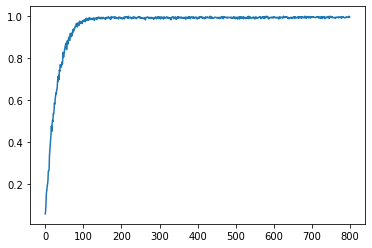

In [43]:
try:
    # the first 600 epochs
    plot_accuracy(history1)
    plot_loss(history1)
    # the next 500 epochs
    plot_accuracy(history2)
    plot_loss(history2)
except:
    pass

### Save/Load Model

In [44]:
with open('jhmdb_le.pkl', 'wb') as f:
    pickle.dump(le, f)
le.classes_.tolist()

['brush_hair',
 'catch',
 'clap',
 'climb_stairs',
 'golf',
 'jump',
 'kick_ball',
 'pick',
 'pour',
 'pullup',
 'push',
 'run',
 'shoot_ball',
 'shoot_bow',
 'shoot_gun',
 'sit',
 'stand',
 'swing_baseball',
 'throw',
 'walk',
 'wave']

In [45]:
model_path = 'jhmdb_openpose_model_15_refit.h5'
ddnet.save_DDNet(rf_net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)